In [17]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload 2

In [19]:
#
import sys
sys.path.append('./')

In [20]:
# General imports
import json
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum

In [21]:
@dataclass
class SchedulerType(Enum):
    """The type of scheduler to use."""

    BASELINE = auto()
    SIMPLE = auto()
    EXTENDED = auto()  

In [22]:
# Configuration
# 1. Number of Jobs in the batch
jobs = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
# 2. Number of machines
machines = {"QUITO": 5, "BELEM": 5}
# 3. Scheduling type
name_schedule = SchedulerType.EXTENDED


In [23]:
# Setup
if name_schedule == SchedulerType.EXTENDED:
    from src.algorithm import MILQ
    bigM = 1000
    timesteps = 2**6

In [24]:
# Scheduler
MILQ.example_problem(bigM, timesteps, "./results/MILQ")


go
Processing times for 0: [0, 0]
Processing times for A: [7, 9]
Processing times for B: [6, 7]
Processing times for C: [11, 8]
Setup times for 0 and 0: [50, 50]
Setup times for 0 and A: [0, 0]
Setup times for 0 and B: [0, 0]
Setup times for 0 and C: [0, 0]
Setup times for A and 0: [50, 50]
Setup times for A and A: [50, 50]
Setup times for A and B: [8, 6]
Setup times for A and C: [7, 6]
Setup times for B and 0: [50, 50]
Setup times for B and A: [6, 9]
Setup times for B and B: [50, 50]
Setup times for B and C: [8, 10]
Setup times for C and 0: [50, 50]
Setup times for C and A: [9, 9]
Setup times for C and B: [10, 11]
Setup times for C and C: [50, 50]
Problem:
[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7ff1631f4c70>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7ff1631f4bb0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7ff1631f4af0>]
Job Capacities:
{'A': 2, 'B': 3, 'C': 5}
Run info
Jobs in define_lp:
['0', '1', '2', '3']
Jobs:
2
3
5
Jobs in set_

  job  qubits machine  capacity  start  end  duration
0   A       2   BELEM         5    9.0  9.0       0.0
1   B       3   BELEM         5    0.0  9.0       9.0
2   C       5   QUITO         5    1.0  9.0       8.0


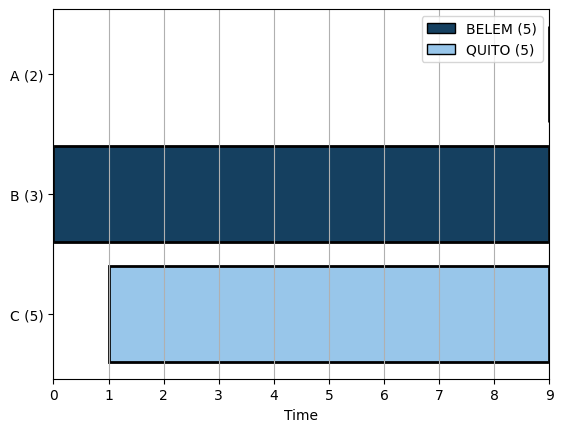

In [25]:
# Visualize
from visualize import visualize_lp

visualize_lp.visualize()




In [ ]:

# Analyze